In [ ]:
''' 
PPCA v1.0 

STEP 4: POPULATION POTENTIAL PER BUILDING & PER CATCHMENT AREA

Author: Perez, Joan

This script estimates population distribution within residential buildings based on floor area. The script filters the buildings to retain
only residential types. Using the centroids of these buildings, it conducts a spatial join with the GHS population data to associate each
building with its respective population values. It then disaggregates the population estimates (VALUE) based on these FA ratios to derive 
a population estimation (Pop_estimation) for each building. This population estimation is then integrated into a pedestrian street network
analysis (graph using cityseer). Points are generated along pedestrian streets at regular intervals, and the potential population is
associated to these points within various catchment areas. The distance between the points to be generated along the network, as well
as the catchment area distances can be parameterized.

Requirements
- A specific working environment (see README on the github page of the project https://github.com/perezjoan/PPCA-codes?tab=readme-ov-file)
- Output file from PPCA_1-2_{Name}_retained ('ghs_populated_{Date}_vector'(Polygon),  GHS population data with non null values)
- Output file from PPCA 3-1_{Name}_TYPE ('osm_buildings_res_type' (Polygon), osm buildings with residential classification null filled by 
Decision Tree Classifier)

Guide to run PPCA STEP 4
- Fill 0.1 box and run the script

Output
- A geopackage file with a two layers
    * 'osm_buildings_pop_estimate' (Points), centroid of osm residential and mixed-use buildings with population estimations
    * 'points_catchment_stats' (Points), points generated along the pedestrian streets with population potential for different catchment
areas

Acknowledgement
This resource was produced within the emc2 project, which is funded by ANR (France), FFG (Austria), MUR (Italy) and Vinnova (Sweden) under
the Driving Urban Transition Partnership, which has been co-funded by the European Commission.

License: Attribution-ShareAlike 4.0 International - CC-BY-SA-4.0 license
'''

In [1]:
###########################################################################################################################################

# 0.1 : Box to fil with informations

# Name of the case study
Name = 'Nice'

# Recall the GHS date
ghs_date = 2020

# Distance between each point created along streets (catchment areas are computed on those points) (in meters)
points_distance = 25

# Offset distance : distance from each street crossing to set the first point (in meters)
offset_distance = 10

# Distances for catchement areas (in meters)
distances = [400, 800, 1200]

# Set your local path to QGIS
qgis_path = "C:/Program Files/QGIS 3.x/apps/qgis"

###########################################################################################################################################

In [2]:
# 0.2 : libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import momepy
from cityseer.tools import mock, graphs, plot, io
from cityseer.metrics import networks, layers
import matplotlib.pyplot as plt
from qgis.core import QgsApplication, QgsProcessingFeedback
from qgis.analysis import QgsNativeAlgorithms
import processing
import sys
from shapely.geometry import LineString, MultiLineString, Point
from shapely import wkb
from shapely.ops import split
import fiona
import sqlite3
import os

# 0.3 Data preparation
gpkg = f'PPCA_1-2_{Name}_retained.gpkg'
population = gpd.read_file(gpkg, layer=f'ghs_populated_{ghs_date}_vector')
gdf_lines = gpd.read_file(gpkg, layer="pedestrian_streets")
gpkg = f'PPCA_3-1_{Name}_IND_FL.gpkg'
building = gpd.read_file(gpkg, layer='osm_buildings_res_type')
gpkg_bis = f'PPCA_1-2_{Name}_retained.gpkg'
gpkg_ter = f'PPCA_4-1_{Name}_POP_CAT.gpkg'

## 1. POPULATION TO BUILDINGS

# 1.1 JOIN GHS POPULATION TO BUILDINGS

# Ensure population GeoDataFrame has the same CRS as building GeoDataFrame
population = population.to_crs(building.crs)

# Keep only residential buildings
building = building[building['type_filled'] == 1]

# Create a copy of building and calculate centroids
building_centroids = building.copy()
building_centroids['geometry'] = building_centroids.geometry.centroid

# Drop existing columns named 'index_left' and 'index_right' if they exist
building_centroids = building_centroids.drop(columns=['index_left', 'index_right'], errors='ignore')
population = population.drop(columns=['index_left', 'index_right'], errors='ignore')

# Perform the spatial join with centroids
joined_data = gpd.sjoin(building_centroids, population, how='left', predicate='intersects', lsuffix='left', rsuffix='right')

# 1.2 DISAGGREGATE GHS VALUES BASED ON FLOOR-AREA RATIO

# Calculate the total FA sum for each index_right
fa_sum = joined_data.groupby('index_right')['FA'].sum().rename('FA_sum').reset_index()

# Merge the FA_sum back to the joined_data
joined_data = joined_data.merge(fa_sum, on='index_right')

# Calculate the FA ratio
joined_data['FA_ratio'] = joined_data['FA'] / joined_data['FA_sum']

# Disaggregate VALUE relative to the FA ratio
joined_data['Pop_estimation'] = joined_data['VALUE'] * joined_data['FA_ratio']

## 2. POPULATION TO CATCHMENT AREAS

# 2.1 POINTS ALONG PEDESTRIAN STREET NETWORK
# Function to generate points along a line at given intervals with an offset
def generate_points(line, interval=points_distance, offset=offset_distance):
    points = []
    distance = offset
    while distance < line.length:
        point = line.interpolate(distance)
        points.append(point)
        distance += interval
    return points

# Create an empty GeoDataFrame to store the generated points
gdf_points = gpd.GeoDataFrame(columns=['geometry'], crs=gdf_lines.crs)

# Generate points along each street
all_points = []
for idx, row in gdf_lines.iterrows():
    line = row.geometry
    if isinstance(line, LineString):
        points = generate_points(line, interval=points_distance, offset=offset_distance)
        all_points.extend(points)
    elif isinstance(line, MultiLineString):
        for subline in line:
            points = generate_points(subline, interval=points_distance, offset=offset_distance)
            all_points.extend(points)

# Create a GeoDataFrame from the generated points
gdf_points = gpd.GeoDataFrame(geometry=all_points, crs=gdf_lines.crs)

# 2.2 SPLIT STREETS ACCORDING TO POINT LOCATIONS

# Create shifted points
gdf_point_1 = gdf_points.copy()
gdf_point_2 = gdf_points.copy()

gdf_point_1.geometry = gdf_point_1.geometry.apply(lambda geom: Point(geom.x - 0.1, geom.y))
gdf_point_2.geometry = gdf_point_2.geometry.apply(lambda geom: Point(geom.x + 0.1, geom.y))

# Create connecting lines 
lines = []
for point1, point2 in zip(gdf_point_1.geometry, gdf_point_2.geometry):
    line = LineString([point1, point2])
    lines.append(line)

# Create a GeoDataFrame from the lines
gdf_lines_between_points = gpd.GeoDataFrame(geometry=lines, crs=gdf_points.crs)
gdf_lines_between_points.to_file(gpkg_ter, layer="points_catchment_stats", driver="GPKG")

# Initialize QGIS Application
sys.path.append(qgis_path)
QgsApplication.setPrefixPath(qgis_path, True)
qgs = QgsApplication([], False)
qgs.initQgis()

# Add processing algorithms to registry
from processing.core.Processing import Processing
Processing.initialize()

# Split lines
splited_layer = "splited_street"
processing.run("native:splitwithlines",
               {'INPUT':f"{gpkg_bis}|layername=pedestrian_streets",
                'LINES':f"{gpkg_ter}|layername=points_catchment_stats",
                'OUTPUT':f'ogr:dbname=\'{gpkg_ter}\' table="{splited_layer}" (geom)'})

# 2.3 COMPUTE STATS ALONG GRAPH

gdf_lines = gpd.read_file(gpkg_ter, layer="splited_street")

# Multilines to singlelines
gdf_lines = gdf_lines.explode(index_parts=True)

nx_momepy = io.nx_from_generic_geopandas(gdf_lines)

nodes_gdf, edges_gdf, network_structure = io.network_structure_from_nx(
    nx_momepy, crs=gdf_lines.crs.to_epsg()
)

population = gpd.GeoDataFrame(joined_data, geometry='geometry')
population.index = population.index.astype(str)

# Assign GeoDataFrame to network
assigned_population_gdf = layers.assign_gdf_to_network(
    data_gdf=population,
    network_structure=network_structure,
    max_netw_assign_dist=400,
)

# Assign GeoDataFrame to network with an appropriate max_netw_assign_dist
data_map, assigned_population_gdf = layers.assign_gdf_to_network(
    data_gdf=population,
    network_structure=network_structure,
    max_netw_assign_dist=400,
)

# compute_stats function
nodes_gdf, numerical_gdf = layers.compute_stats(
    data_gdf=assigned_population_gdf,
    stats_column_label="Pop_estimation",
    nodes_gdf=nodes_gdf,
    network_structure=network_structure,
    max_netw_assign_dist=400,
    distances=distances,
)

ERROR:fiona._env:PPCA_1-2_Nice_retained.gpkg: No such file or directory
C:\Users\jperez\anaconda3\envs\PPCA1\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\jperez\anaconda3\envs\PPCA1\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


DriverError: PPCA_1-2_Nice_retained.gpkg: No such file or directory

In [4]:
###########################################################################################################################################

## APPENDICES

# A1. Save Outputs
joined_data.to_file(gpkg_ter, layer='osm_buildings_pop_estimate', driver="GPKG")
nodes_gdf.to_file(gpkg_ter, layer='points_catchment_stats', driver="GPKG")

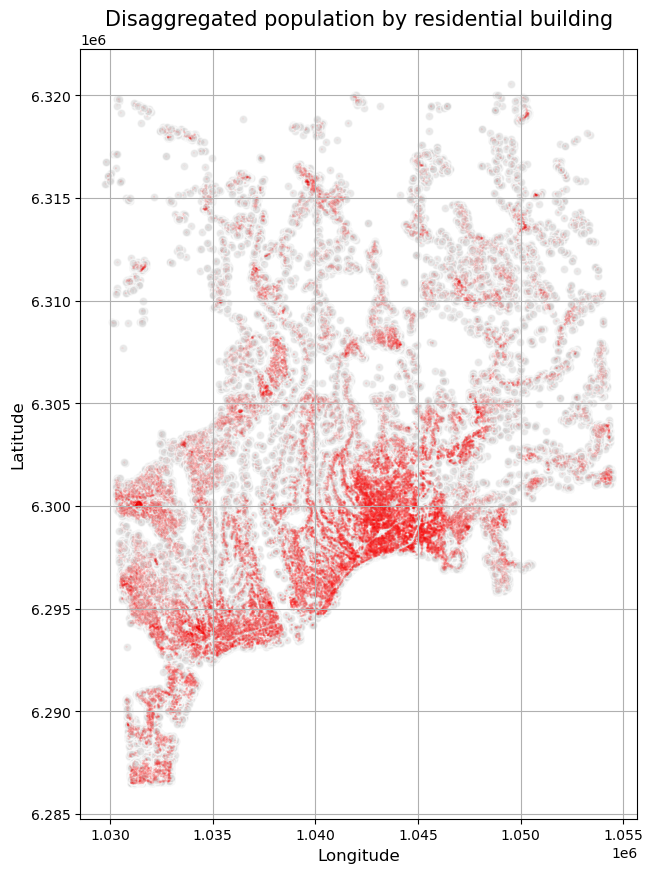

In [6]:
# A2. Map of population
# Size of the markers
marker_size_scale = 0.01

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Plot the base map - assuming population GeoDataFrame provides the base map context
population.plot(ax=ax, color='lightgrey', edgecolor='white', alpha=0.5)

# Plot the centroids with VALUE_disaggregated
joined_data.plot(ax=ax, color='red', markersize=joined_data['Pop_estimation'] * marker_size_scale, alpha=0.2)

# Adding titles and labels
plt.title('Disaggregated population by residential building', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True)
plt.show()

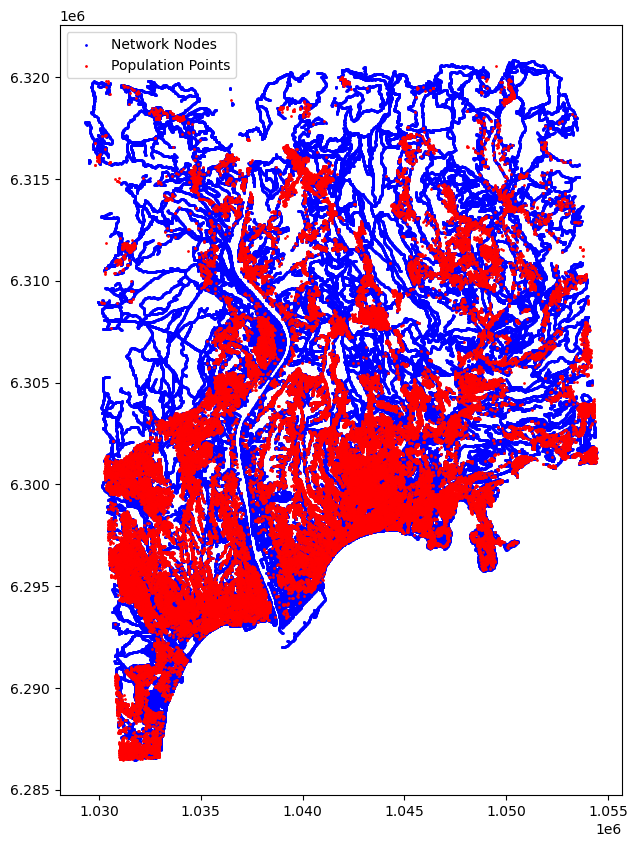

In [8]:
# A3. Nodes vs building centroids with population
# Visualize the network and the population points
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
nodes_gdf.plot(ax=ax, color='blue', markersize=1, label='Network Nodes')
population.plot(ax=ax, color='red', markersize=1, label='Population Points')
plt.legend()
plt.show()

In [ ]:
# A4. Nodes with raw population